In [9]:
# 📦 Imports
import pandas as pd
import pickle
import numpy as np
np.bool = bool
np.int = int
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# 📥 Load Preprocessed Data
df = pd.read_csv('cicids2017_preprocessed_phase1.csv')

# Separate features and label
X = df.drop('Label', axis=1)
y = df['Label']

# 📥 Load Trained Model
with open('../models/champion_phase2.pkl', 'rb') as file:
    model = pickle.load(file)

# ✅ Quick Check
print("Data Shape:", X.shape)
print("Model Loaded Successfully.")


Data Shape: (2827876, 78)
Model Loaded Successfully.


In [11]:
# Lowercase all columns to match training
X.columns = X.columns.str.lower()

# Predict probabilities
y_pred_proba = model.predict_proba(X)

# Pick confident and low confidence samples
confident_idx = np.argmax(np.max(y_pred_proba, axis=1))
low_confidence_idx = np.argmin(np.max(y_pred_proba, axis=1))

print("High-confidence sample index:", confident_idx)
print("Low-confidence sample index:", low_confidence_idx)

# 1. Select your samples
high_conf_sample = X.iloc[[confident_idx]]  # confident sample
low_conf_sample = X.iloc[[low_confidence_idx]]  # low confidence sample


High-confidence sample index: 32
Low-confidence sample index: 2296201


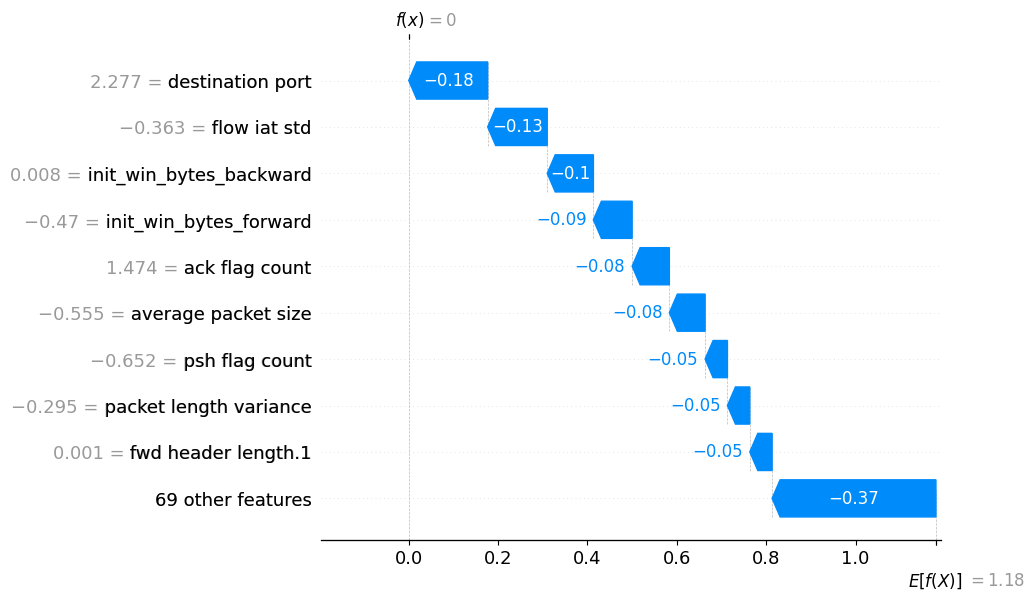

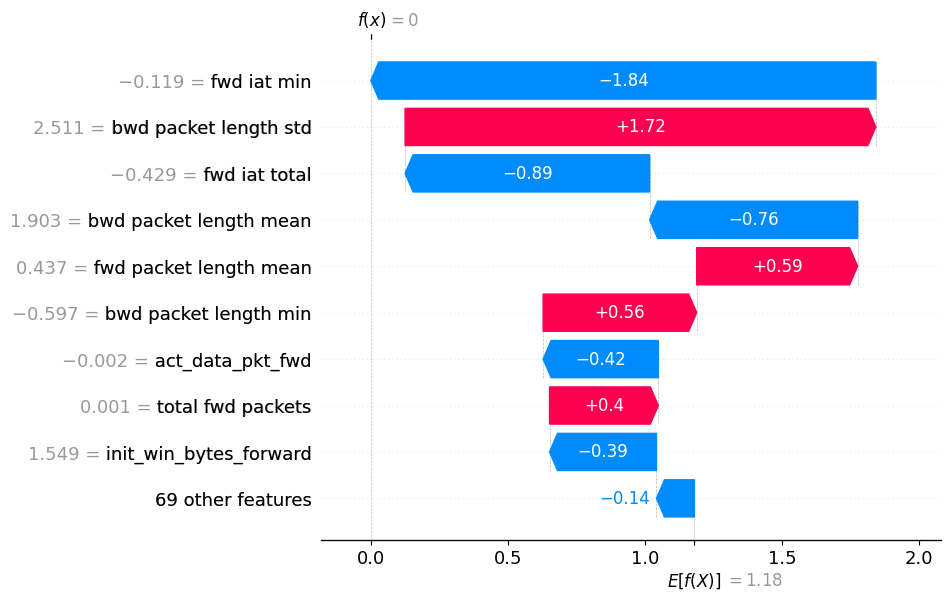

In [13]:
explainer = shap.Explainer(model.predict, X)
shap_values_high = explainer(high_conf_sample)
shap_values_low = explainer(low_conf_sample)

# SHAP Waterfall Plots
shap.plots.waterfall(shap_values_high[0], show=True)
shap.plots.waterfall(shap_values_low[0], show=True)


In [14]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns,
    class_names=['Benign', 'Malicious'],
    mode='classification'
)

lime_exp_high = explainer_lime.explain_instance(high_conf_sample.values[0], model.predict_proba)
lime_exp_low = explainer_lime.explain_instance(low_conf_sample.values[0], model.predict_proba)

# Display LIME results
lime_exp_high.show_in_notebook()
lime_exp_low.show_in_notebook()


Permutation explainer: 501it [07:58,  1.03it/s]                                                                        


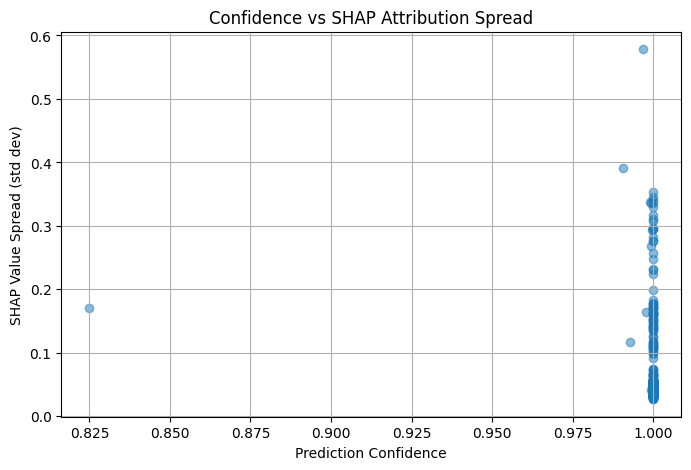

In [15]:
# SHAP value spreads
shap_values_all = explainer(X.sample(n=500, random_state=42))
confidences_all = np.max(model.predict_proba(X.sample(n=500, random_state=42)), axis=1)
spreads = [np.std(val.values) for val in shap_values_all]

# Plot confidence vs SHAP value spread
plt.figure(figsize=(8,5))
plt.scatter(confidences_all, spreads, alpha=0.5)
plt.xlabel("Prediction Confidence")
plt.ylabel("SHAP Value Spread (std dev)")
plt.title("Confidence vs SHAP Attribution Spread")
plt.grid(True)
plt.show()


In [16]:
import pandas as pd

summary_df = pd.DataFrame({
    "Confidence": confidences_all,
    "SHAP Spread": spreads
})

summary_df.describe()


,Confidence,SHAP Spread
count,500.000000,500.000000
mean,0.999595,0.067894
std,0.007843,0.067115
min,0.825009,0.026777
25%,0.999998,0.038272
50%,0.999999,0.043436
75%,1.000000,0.053235
max,1.000000,0.578351


In [17]:
# Save explanations (optional)
summary_df.to_csv("shap_confidence_spread_summary.csv", index=False)


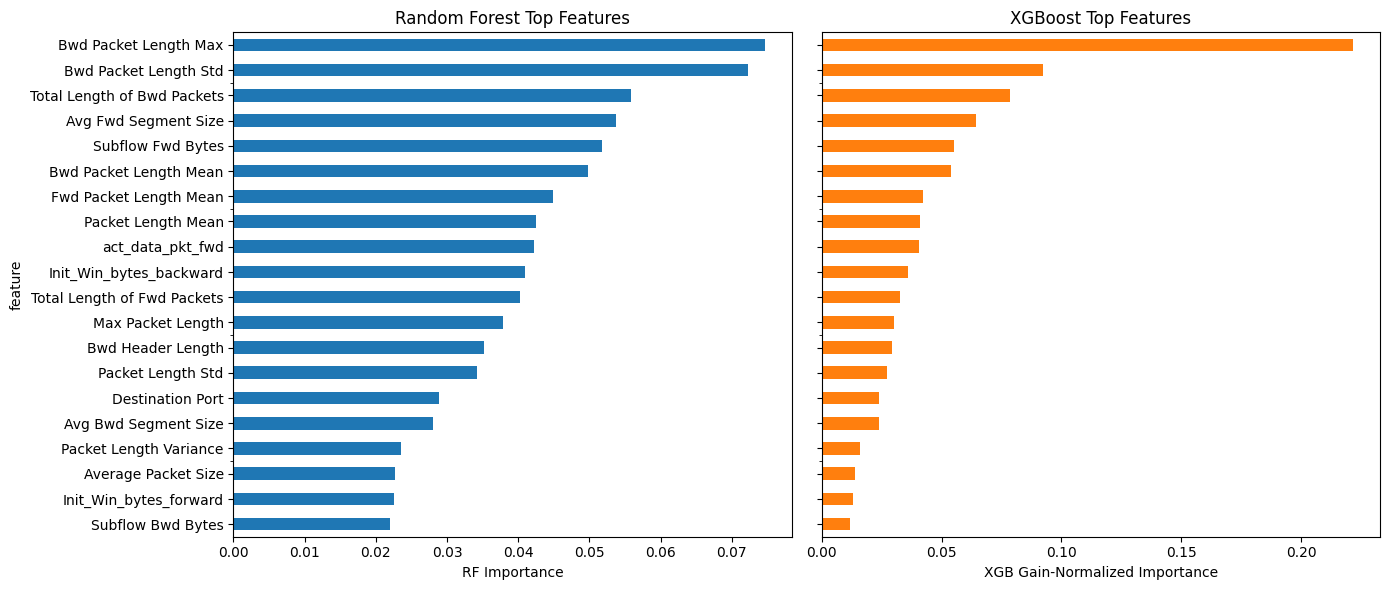


Feature Importance Summary (top 20 each):


,overlap,rf_only,xgb_only
0,Average Packet Size,Flow IAT Mean,Bwd Header Length
1,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Packet Length Mean
2,Avg Fwd Segment Size,Fwd Packet Length Max,act_data_pkt_fwd
3,Bwd Packet Length Max,NaN,NaN
4,Bwd Packet Length Mean,NaN,NaN
5,Bwd Packet Length Std,NaN,NaN
6,Destination Port,NaN,NaN
7,Init_Win_bytes_backward,NaN,NaN
8,Init_Win_bytes_forward,NaN,NaN
9,Max Packet Length,NaN,NaN


In [24]:
# ─── 4.2 Feature Attribution Shift ─────────────────────────────────────────────
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Load your selected_features list (the exact order used during Phase 1 training)
with open('feature_list.json','r') as f:
    selected_features = json.load(f)

# 📥 Load both trained models
with open('rf_model.pkl','rb') as f:
    rf = pickle.load(f)
with open('best_model.pkl','rb') as f:
    xgb = pickle.load(f)

# 📋 Build RF feature‐importance DataFrame (one importance per selected feature)
rf_imp = pd.DataFrame({
    'feature': selected_features,
    'rf_importance': rf.feature_importances_
})

# 📋 Build XGB gain‐based importance DataFrame
#   we only consider features that actually appear in the booster.get_score() dict
xgb_booster = xgb.get_booster()
gain_dict = xgb_booster.get_score(importance_type='gain')

# Convert to DataFrame, then normalize to sum=1
xgb_imp = (
    pd.DataFrame.from_dict(gain_dict, orient='index', columns=['xgb_gain'])
      .rename_axis('feature')
      .reset_index()
)
xgb_imp['xgb_importance'] = xgb_imp['xgb_gain'] / xgb_imp['xgb_gain'].sum()

# ── Merge importances ────────────────────────────────────────────────────────────
df_imp = (
    rf_imp.merge(xgb_imp[['feature','xgb_importance']], on='feature', how='left')
          .fillna(0)   # any feature RF had but XGB didn't will get zero gain
)

# ── Pick top N from each model ───────────────────────────────────────────────────
top_n = 20
rf_top  = df_imp.nlargest(top_n, 'rf_importance')
xgb_top = df_imp.nlargest(top_n, 'xgb_importance')

# ── Plot side‐by‐side bar charts ─────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=True)

rf_top.sort_values('rf_importance')\
      .plot.barh(x='feature', y='rf_importance', ax=ax1, color='C0', legend=False)
ax1.set_title('Random Forest Top Features')
ax1.set_xlabel('RF Importance')

xgb_top.sort_values('xgb_importance')\
       .plot.barh(x='feature', y='xgb_importance', ax=ax2, color='C1', legend=False)
ax2.set_title('XGBoost Top Features')
ax2.set_xlabel('XGB Gain‐Normalized Importance')

plt.tight_layout()
plt.show()

# ── Build overlap/unique summary table ───────────────────────────────────────────
rf_set  = set(rf_top['feature'])
xgb_set = set(xgb_top['feature'])

summary = pd.DataFrame({
    'overlap': pd.Series(sorted(rf_set  & xgb_set)),
    'rf_only': pd.Series(sorted(rf_set  - xgb_set)),
    'xgb_only':pd.Series(sorted(xgb_set - rf_set))
})

print("\nFeature Importance Summary (top 20 each):")
display(summary)
